# CADC Astroquery
Astroquery is package that provides a set of tools to query astronomical databases. In this tutorial, we will focus on the CADC package of astroquery, which queries data provided by the Canadian Astronomical Data Centre (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). This tutorial will go through an example of runing a query to displaying an image. We will gather images from HST and CFHT, do a cutout of the area we want, and display the the images. (Note: I haven't added PansSTARRS DR1g data yet)


TODO: Clean up links!

# Tutorial
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
$ pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:
TODO: Remove $

```
$ # If you have a github account:
$ git clone git@github.com:astropy/astroquery.git
$ # If you do not:
$ git clone https://github.com/astropy/astroquery.git
$ cd astroquery
$ python setup.py install
```

More information about astroquery can be found at the github repository https://github.com/astropy/astroquery.

Now, onto the tutorial. The first step is to import the CADC module from astroquery.

In [315]:
from astroquery.cadc import Cadc
cadc = Cadc()


## Querying By Name

TODO: Ask what energy band for HST images

Now we can query the CADC database and retreive the data we want. Let's take a look at MegaPipe data in the D2 field, and compare it to HST images in the same area. The MegaPipe collection is data collected by the CFHT MegaCam and stacked at the CADC (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/cfht/). The D2 field is in the region `10:00:28 02:12:30` (https://www.cfht.hawaii.edu/Science/CFHLS/cfhtlsdeepwidefields.html) so let's query around that area for both CFHT and HST data. We also want to restrict results to calibrated images of good quality.

For MegaPipe images, we want energy bands in the R ($\lambda_{eff} = 658 nm$) or I ($\lambda_{eff} = 806 nm$) range (https://en.wikipedia.org/wiki/Photometric_system).

For HST images, energy bands use the WFC system, and right now I'm not sure which filter we would like (http://www.stsci.edu/hst/wfc3/ins_performance/ground/components/filters).

First we grab the coordinates of the D2 field:


### Method 1: Query Name
The simplest way to query data by region is to use the `query_region` function. It takes coordinates and a collection source (optional) and returns all the results that contain the cordinates. If radius is passed in, then it returns results that intersect with that area. After querying, we can further filter down the results using boolean masks on the data.


In [316]:
# To fetch a single table object
#table = cadc.get_table(table='caom2.caom2.Plane')
#[print(col.name) for col in table.columns];


In [335]:
#http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls05D2ah&submit=SIMBAD+search
#http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls06D2fb&submit=SIMBAD+search
ang_to_m = lambda ang: ang*1e-10
object_name = '05D2ah'

query_vars = { 'object_name': object_name, 'lower': ang_to_m(3000), 'upper': ang_to_m(10000)}
results = cadc.query_name(object_name)

results_filter = lambda lower, upper: ((results['energy_bounds_lower']>= lower) &\
                                       (results['energy_bounds_upper']<= upper) &\
                                       (results['dataProductType'] == 'image'))

filtered_results = results[results_filter(query_vars['lower'], query_vars['upper'])]

print('Number of results: {}'.format(len(filtered_results)))
filtered_results.colnames

Number of results: 4


['caomObservationURI',
 'sequenceNumber',
 'proposal_keywords',
 'target_standard',
 'target_redshift',
 'target_moving',
 'target_keywords',
 'targetPosition_equinox',
 'targetPosition_coordinates_cval1',
 'targetPosition_coordinates_cval2',
 'telescope_geoLocationX',
 'telescope_geoLocationY',
 'telescope_geoLocationZ',
 'telescope_keywords',
 'instrument_keywords',
 'environment_seeing',
 'environment_humidity',
 'environment_elevation',
 'environment_tau',
 'environment_wavelengthTau',
 'environment_ambientTemp',
 'environment_photometric',
 'members',
 'typeCode',
 'metaChecksum',
 'obsID',
 'accMetaChecksum',
 'collection',
 'observationID',
 'algorithm_name',
 'type',
 'intent',
 'metaRelease',
 'proposal_id',
 'proposal_pi',
 'proposal_project',
 'proposal_title',
 'target_name',
 'target_type',
 'targetPosition_coordsys',
 'telescope_name',
 'requirements_flag',
 'instrument_name',
 'lastModified',
 'maxLastModified',
 'caomPlaneURI',
 'caomPublisherID',
 'calibrationLevel',
 

Let's take a look at the column names of the results to see what we can filter down. In this case, we want to look at the `calibrationLevel`, `dataProductType`, `quality_flag`, `target_name`, and `energy_bandpassName` columns. Now we can take a look at the results from the query. The results are returned as an astropy table, so we can use the `show_in_notebook` method to nicely render our results.

In [318]:
columns_subset = ['productID', 'collection', 'observationID', 'energy_bandpassName', 'calibrationLevel', \
                  'position_dimension_naxis1', 'position_dimension_naxis2', 'intent', 'target_name', \
                  'telescope_name', 'instrument_name', 'position_bounds', 'dataProductType']

filtered_results[columns_subset].show_in_notebook()

idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,GN-2004B-Q-16-82-004,GEMINI,GN-2004B-Q-16-82-004,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.3233722583425 1.8422707315077402 150.32331577433644 1.884432219938359 150.41667813377651 1.8846451600602616 150.41673238354682 1.842483668996208],image
1,GN-2004B-Q-16-82-002,GEMINI,GN-2004B-Q-16-82-002,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32338008674503 1.8422293367578795 150.3233228712942 1.8843909242644925 150.4166869298773 1.8846041366091688 150.41674191109584 1.8424425464303613],image
2,GN-2004B-Q-16-82-001,GEMINI,GN-2004B-Q-16-82-001,r,1,1056,2304,science,05D2ah,Gemini-North,GMOS-N,[150.3233815847936 1.8422289721864904 150.32332330929293 1.8850392218425782 150.41668783940196 1.8852524827476165 150.41674384628485 1.8424422303694865],image
3,GN-2004B-Q-16-82-003,GEMINI,GN-2004B-Q-16-82-003,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32337776170982 1.842182616781287 150.32332075994816 1.8843441626954263 150.4166841361924 1.8845574313207447 150.41673890379732 1.8423958827459035],image


### Method 2: ADQL
The second method is to bundle the query and filtering in one using ADQL. In this case, we bundle both the CFHT and HST results into one query. In this case, we filter all results that contain the area of the coordinates within a certain radius.

In [319]:
query = '''SELECT *
FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE (( Observation.target_name LIKE '%{object_name}%' )
AND ( Plane.energy_bounds_lower >= {lower} )
AND ( Plane.energy_bounds_upper <= {upper} ) 
AND ( Plane.dataProductType = 'image'))'''.format(**query_vars)

job = cadc.run_query(query, 'sync')
results = job.get_results()

results[columns_subset].show_in_notebook()

idx,productID,collection,observationID,energy_bandpassName,calibrationLevel,position_dimension_naxis1,position_dimension_naxis2,intent,target_name,telescope_name,instrument_name,position_bounds,dataProductType
,,,,,,,,,,,,deg,
0,GN-2004B-Q-16-82-004,GEMINI,GN-2004B-Q-16-82-004,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.3233722583425 1.8422707315077402 150.32331577433644 1.884432219938359 150.41667813377651 1.8846451600602616 150.41673238354682 1.842483668996208],image
1,GN-2004B-Q-16-82-002,GEMINI,GN-2004B-Q-16-82-002,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32338008674503 1.8422293367578795 150.3233228712942 1.8843909242644925 150.4166869298773 1.8846041366091688 150.41674191109584 1.8424425464303613],image
2,GN-2004B-Q-16-82-001,GEMINI,GN-2004B-Q-16-82-001,r,1,1056,2304,science,05D2ah,Gemini-North,GMOS-N,[150.3233815847936 1.8422289721864904 150.32332330929293 1.8850392218425782 150.41668783940196 1.8852524827476165 150.41674384628485 1.8424422303694865],image
3,GN-2004B-Q-16-82-003,GEMINI,GN-2004B-Q-16-82-003,r,1,2080,4608,science,05D2ah,Gemini-North,GMOS-N,[150.32337776170982 1.842182616781287 150.32332075994816 1.8843441626954263 150.4166841361924 1.8845574313207447 150.41673890379732 1.8423958827459035],image


Notice how we have the same number of results using both the two methods? Pretty  neat :)

## Selecting Data
Now let's choose two images, find a suitable cutout, download them, and display them. We will use the `get_data_urls` function to actually access the data.

In [320]:
# Get links to the data
urls = cadc.get_data_urls(results)

print(urls)

['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0184.fits.gz?RUNID=hsjl7aj113fn09do', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0183.fits.gz?RUNID=zucavko3d68e33rs', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0185.fits.gz?RUNID=uznp5h6x4ux2js7m']


The stucture of the url's can be broken into a few parts. Take 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHTSG/D2.I.fits?RUNID=tduehvsqxkpsmdez' as an example...
- `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/`: This is the service url. The 'data/pub' ending accesses all public files. For files the requires authorization, there will be a redirect to 'data/auth' which require authorization
- `CFHTSG`: This is the archive name.
- `D2.I.fits`: This is the file name.
- `RUNID=f842u7t5dzws8mgy`: These are additional query parameters. I don't exactly know what this means!

The urls give access to the actual data, so now we can fetch the file, get data to calculate a cutout, open it with the astropy fits module, and display an image!


### Calculating cutouts

One thing to note is that the data products probably contain much more information than we actually need. In order to reduce the amount of data and total processing time, we can request cutouts of the fits files that only contain a slice of information. In order to do a cutout, we need the range of pixels we want, and/or the fits extensions that we want. In this particular case, we want to compare two different files, so we want to do a cutout based on the coordinates we want to look at. In order to do this, we recruit the `cadccutout` package which can transform coordinates to the pixel range used to perform the cutout.


In [328]:
from cadccutout import Transform
from astropy.io import fits
from astropy.coordinates import SkyCoord

# TODO figure out why ext causes hst request to error
### TODO fix cutout bug where closing indicer smaller than openig indices (then causes cutout error)
def cutout_pixels_from_position_with_ext(cutout_position, url, ext=0):
    transform = Transform()
    to_cutout_string = lambda pix_range: '[{}][{}:{},{}:{}]'.format(ext, pix_range[0][0], pix_range[0][1], 
                                                                pix_range[1][0], pix_range[1][1])
    try:
        header = fits.getheader(url, ext)
        hdu_pixels = transform.world_to_pixels([cutout_position], header)
        return to_cutout_string(hdu_pixels.get_ranges())
    except TypeError:
        return cutout_pixels_from_position_with_ext(cutout_position, url, ext=ext+1) if ext==0 else None

def cutout_pixels_from_position(cutout_position, url, ext=0):
    transform = Transform()
    to_cutout_string = lambda pix_range: '[{}:{},{}:{}]'.format(pix_range[0][0], pix_range[0][1], 
                                                                pix_range[1][0], pix_range[1][1])
    try:
        header = fits.getheader(url, ext)
        hdu_pixels = transform.world_to_pixels([cutout_position], header)
        return to_cutout_string(hdu_pixels.get_ranges())
    except TypeError:
        return cutout_pixels_from_position(cutout_position, url, ext=ext+1) if ext==0 else None
    
c = SkyCoord('10h01m28.728s', '+01d51m45.83s', frame='icrs', unit='deg')
coordinates = { 'ra': c.ra.degree, 'dec': c.dec.degree, 'radius': 0.005}
cutout_region_string = 'CIRCLE {ra} {dec} {radius}'.format(**coordinates)

cutouts = [cutout_pixels_from_position_with_ext(cutout_region_string, url) for url in urls]

print(cutouts)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


['[1][757:1251,2073:2567]', '[1][759:1253,2073:2567]', '[1][379:627,1036:1284]', '[1][761:1255,2073:2567]']


### Fetching the Data
With the cutout values, we can now download the data. There are many different methods to perform a cutout, but today we will add the cutout string to the parameter in the request. More information about requesting CADC data can be found here: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/.


In [329]:
import re
import requests
from astropy.wcs import WCS

#TODO: Make this read file if already there
#TODO: Catch 400 errors
def download_url_to_file(url, cutout=None, data_dir='data'):
    '''Takes a url, downloads the resource, saves it in the data directory with the
    name specified in the response Content Disposition, and returns the file path and name'''

    def get_filename_from_response(response):
        content_disposition = response.headers['Content-Disposition']
        return re.findall("filename=(.+)", content_disposition)[0]

    resp = requests.get(url, params={'cutout': cutout}) if cutout else requests.get(url)
    fname = get_filename_from_response(resp)
    file_name_and_path = '{data_dir}/{fname}'.format(data_dir=data_dir, fname=fname)
    # Note: wb will overwrite if something is already there
    with open(file_name_and_path, 'wb') as f:
        f.write(resp.content)
        
    return file_name_and_path

def get_image_data(file, ext=0):
    '''Returns the image data and wcs coordinate data of a fits file at the given extension'''
    with fits.open(file, ignore_missing_end=True) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w

def get_image_data_from_url(url, cutout=None, ext=0):
    '''Returns the image data and wcs coordinate data of a fits file at the given extension'''
    data_url = url + '&cutout={}'.format(cutout) if cutout else url
    with fits.open(data_url, ignore_missing_end=True) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w



In [302]:
# To save to a file then read to image data
#fname_list = [download_url_to_file(url, cutout=cutout) for url, cutout in zip(urls, cutouts)]
#data_list = [get_image_data(fname) for fname in fname_list]


XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  495 / length of data axis 1                          NAXIS2  =                  495 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     BZERO   =                32768 / offset data range to that of unsigned short    BSCALE  =                    1 / default scaling factor                         INHERIT =                    F / inherit the primary header                     DATATYPE= 'Intensity'          / Type of Data                                   CTYPE1  = 'RA---TAN'           / R.A. in tangent plane projection               CRPIX1  = 2.464167887825300E+02 / Ref pi

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  249 / length of data axis 1                          NAXIS2  =                  249 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     BZERO   =                32768 / offset data range to that of unsigned short    BSCALE  =                    1 / default scaling factor                         INHERIT =                    F / inherit the primary header                     DATATYPE= 'Intensity'          / Type of Data                                   CTYPE1  = 'RA---TAN'           / R.A. in tangent plane projection               CRPIX1  = 1.234584083520290E+02 / Ref pi

In [330]:
# To read from url
# Use this for myBinder
data_list = [get_image_data_from_url(url, cutout=cutout) for url, cutout in zip(urls, cutouts)]


Filename: /home/badune/.astropy/cache/download/py3/7cacd2d0151f6c6cce20da8897fe95de
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (495, 495)   int16 (rescales to uint16)   


Filename: /home/badune/.astropy/cache/download/py3/cd742b56967f23414ab936300a3f266c
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (495, 495)   int16 (rescales to uint16)   


Filename: /home/badune/.astropy/cache/download/py3/4b92486a04c50a2dc963b968e4d98f03
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (249, 249)   int16 (rescales to uint16)   


Filename: /home/badune/.astropy/cache/download/py3/1ea081cb71a891d9e7a7e8c10baddc59
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      -1 PrimaryHDU      39   (495, 495)   int16 (rescales to uint16)   


The astropy WCS module gives position information about the image pixels. We can take a look at the position range of the HST and CFHT images and check to see how close the cutout of the CFHT image is to the HST image.

In [332]:
def print_position_range(image_data, w):
    px = [0, image_data.shape[0]-1]
    py = [0, image_data.shape[1]-1]
    ra, dec = w.all_pix2world(px, py, 0)
    print('ra: ', ra)
    print('dec: ', dec)
    
print('Img 1 Position Range')
image_data, w = data_list[0][0], data_list[0][1]
print_position_range(image_data, w)

Img 1 Position Range
ra:  [150.37472252 150.36470059]
dec:  [1.85772272 1.86771325]


Looks pretty close! Although seems like one axis is flipped... but now we can print out the images!!! First lets print out both side by side.

In [333]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, PowerStretch, ImageNormalize, PercentileInterval, MinMaxInterval

#TODO: Add lables and titles!
#TODO: look and see how to make imshow better
def print_image_stats(image_data):
    stats = {'min': np.nanmin(image_data), 'max': np.nanmax(image_data), 'mean': np.nanmean(image_data), 
            'std': np.nanstd(image_data)}
    print('Min: {min} \nMax: {max} \nMean: {mean}\nStdev: {std}'.format(**stats))

def plot_image_list(data_list, geo=None):

    if geo is None:
        geo = (1, len(data_list)) #nrows, ncols
        
    fig = plt.figure(figsize=(20,10))
    for idx, image in enumerate(data_list):
        image_data, wcs = image[0], image[1]
        image_data_norm = ImageNormalize(image_data, interval=MinMaxInterval(), stretch=LinearStretch())
        ax = plt.subplot(geo[0], geo[1], idx+1, projection=wcs)
        ax.imshow(image_data, norm=image_data_norm, cmap='gray')
        ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')
    
def plot_dual_wcs_images(data_list):
    image_data_a, wcs_a = data_list[0]
    image_data_b, wcs_b = data_list[1]
    
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(projection=wcs_a)
    ax.set_xlim(-0.5, image_data_a.shape[1] - 0.5)
    ax.set_ylim(-0.5, image_data_a.shape[0] - 0.5)
    
    # imshow
    image_data_a_norm = ImageNormalize(image_data_a, interval=PercentileInterval(99), stretch=LinearStretch())
    ax.imshow(image_data_a, norm=image_data_a_norm, origin='lower')
    
    #TODO: Make smart contour levels based on normalized data
    # contour
    print(image_data_b.max())
    image_data_b_norm = ImageNormalize(image_data_b, interval=PercentileInterval(99), stretch=LinearStretch())
    ax.contour(image_data_b, norm=image_data_b_norm, transform=ax.get_transform(wcs_b), levels=np.linspace(0.5, 1, num=2), colors='red')
    ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')
    

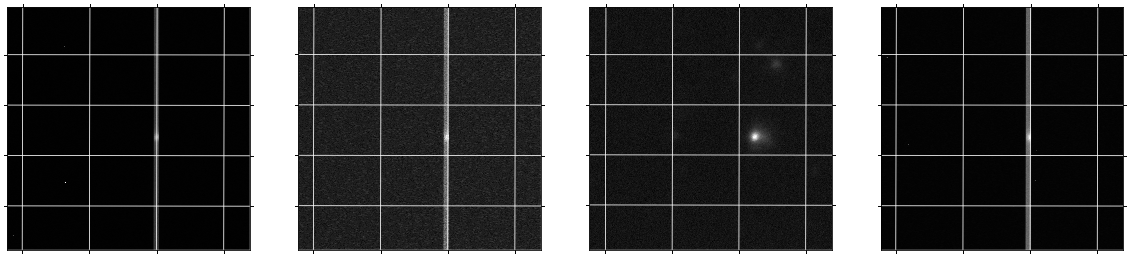

In [324]:
plot_image_list(data_list)

569


/home/badune/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


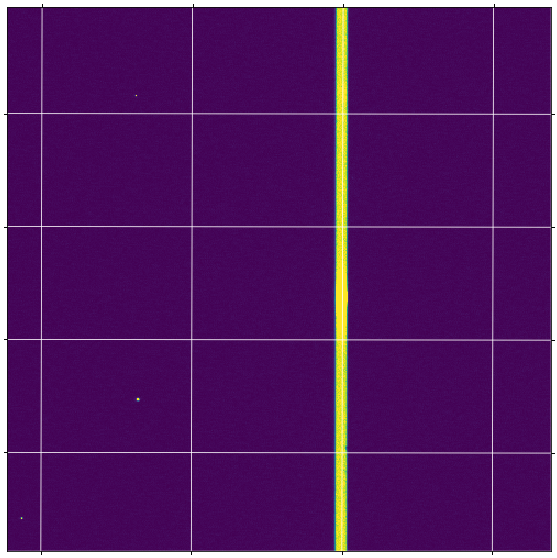

In [334]:
plot_dual_wcs_images(data_list)

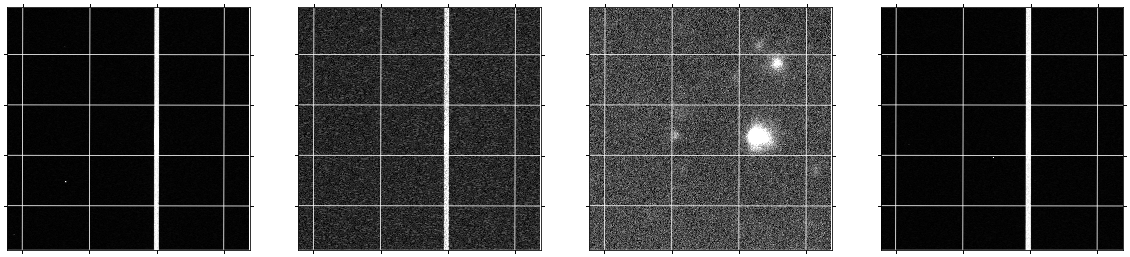

In [336]:
def plot_image_list_shared_axes(data_list, geo=None):
    if geo is None:
        geo = (1, len(data_list)) #nrows, ncols
        
    fig = plt.figure(figsize=(20,10))
    wcs_trans = data_list[1][1]
    image_data_trans = data_list[1][0]
    for idx, image in enumerate(data_list):
        image_data, wcs = image[0], image[1]
        image_data_norm = ImageNormalize(image_data, interval=PercentileInterval(99), stretch=LinearStretch())
        ax = plt.subplot(geo[0], geo[1], idx+1, projection=wcs_trans)
        ax.set_xlim(-0.5, image_data_trans.shape[1] - 0.5)
        ax.set_ylim(-0.5, image_data_trans.shape[0] - 0.5)
        ax.imshow(image_data, transform=ax.get_transform(wcs), norm=image_data_norm, cmap='gray')
        ax.grid(color='white', ls='solid')
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')

plot_image_list_shared_axes(data_list)